## Importing Relevant libraries

In [82]:
import pandas as pd
import numpy as np 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

## Preprocessing and Analysis of the data

Some columns can offset the final result beacuse of their magnitude, so we can normalize such columns for better results.

Outliers can prevent the models to get the true gist of the data and this excess noise can divert the models parameters drastically, that is why it is better to get rid of such data points

In [21]:
def remove_outliers(dataframe: pd.DataFrame,
                    column_name: str) -> object:
    """
    inputs in a dataframe df and a column to consider for outlier removal
    returns a cleaned df with removed outliers
    """
    q1 = dataframe[column_name].quantile(0.25)
    q3 = dataframe[column_name].quantile(0.75)
    iqr = q3 - q1
    upper = np.where(dataframe[column_name] >= (q3 + 1.5 * iqr))
    dataframe.drop(list(upper[0]),
                   inplace=True)
    dataframe = dataframe.reset_index().drop("index",
                                             axis=1)
    return dataframe

In [22]:
def scaling_columns(dataframe: pd.DataFrame,
                    column_names: list):
    scaler = StandardScaler()

    scaled_column = dataframe[column_names].values
    scaled_column = scaler.fit_transform(scaled_column.reshape(len(dataframe), len(column_names)))
    dataframe[column_names] = scaled_column

    return dataframe

In [23]:
def loading_data():
    """
    loads and returns a datset 
    """
    # Importing the dataset
    df = pd.read_excel('Assignment01/Assignment-1_dataset.xlsx')
    #print(df.columns)
    # Cleaning and Preprocessing the dataset
    # Creating a Price Column
    df['prices'] = df['House size (sqft)'] * df['House price of unit area']  # Calculating total price of houses
    return df

In [24]:
df = loading_data()
df.head()

,Transaction date,House Age,Distance from nearest Metro station (km),Number of convenience stores,latitude,longitude,Number of bedrooms,House size (sqft),House price of unit area,prices
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,1,575,37.9,21792.5
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,2,1240,42.2,52328.0
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,3,1060,47.3,50138.0
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,2,875,54.8,47950.0
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,1,491,43.1,21162.1


**Lets look at the features and how are they related to each other to preprocess the dataset**

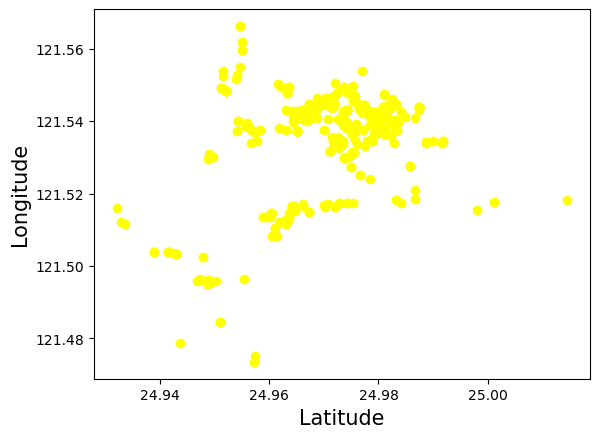

In [25]:
plt.scatter(df.latitude.values,df.longitude.values,c="yellow")
plt.xlabel("Latitude",fontsize=15)
plt.ylabel("Longitude",fontsize=15)
plt.show()

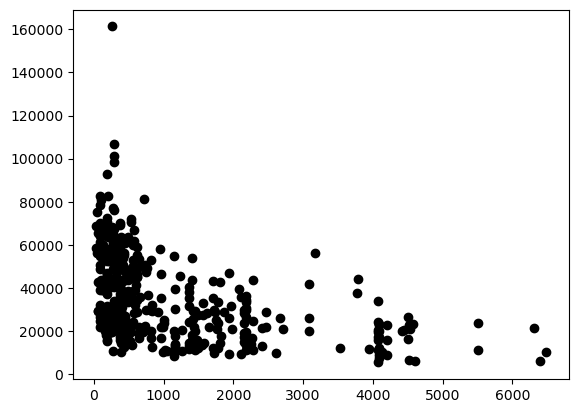

In [26]:
plt.scatter(df['Distance from nearest Metro station (km)'],df.prices.values,c="black")
plt.show()

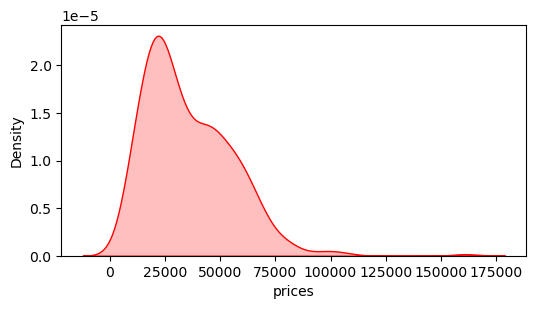

In [27]:
plt.figure(figsize=(6,3))
sns.kdeplot(df['prices'],
            fill=True,
           color = "red")
plt.show()

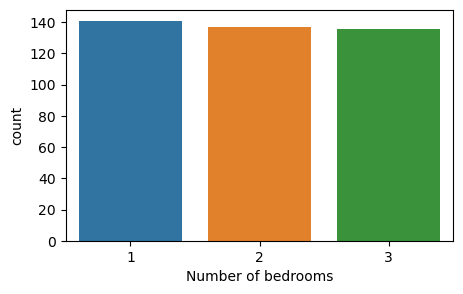

In [28]:
plt.figure(figsize=(5,3))
sns.countplot(x =df["Number of bedrooms"])
plt.show()

# This column is balanced

*  **We can see that Location(latitude-longitude) are making clusters, So it is savvy to make them into a seperate column that will capture the value of both the column  by K-means clustering.**

*  **Distance from nearest Metro station creats a logarithmic curve with price, which means that the near the metro station is the pricy the house is. More or less this doesn't have anything directly to do with distance from metro station but the fact that metro station are mostly located in places that are moving places and market areas with high demand of land.**

*  **The dataset is unbalanced as we have more data of low price houses and less data of expensive houses with some extreme outliers. It is best to get rid of the Outliers.**

In [29]:
def find_categorical_percentages(df:pd.DataFrame,
                                 column_name:str):
    count = df.groupby(column_name).count().reset_index()\
           .sort_values(column_name,ascending=True)["prices"]
    
    percentages = (count/count.sum())*100
    
    return np.round(percentages,2),count

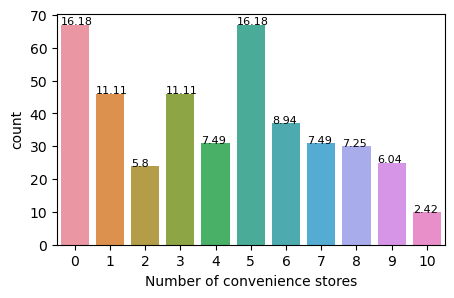

In [30]:
stores_percentages,count = find_categorical_percentages(df,"Number of convenience stores")

a = np.arange(0,11)

plt.figure(figsize=(5,3))
ax = sns.countplot(x =df["Number of convenience stores"])

for index in range(len(stores_percentages)):
    ax.text(a[index]-0.4, count[index], stores_percentages[index], size=8)

plt.show()

**The features are showing meaning and will be valuable for models but certain features like transaction date and house price of unit area should be taken out as it will cause multicollinearity**

**Outliers from prices column will be removed using remove_outliers function and distance from nearest metros should be scaled.**

**We need to convert the location features i.e, latitude and longitude to a single feature using KMeans clustering to avoid loss of information and increase the accuracy of the model.**

In [31]:
def processing_data():
    """
    processes and cleans the dataset and returns a cleaned dataframe
    """
    df = loading_data()
    # Getting rid of the outliers
    df = remove_outliers(dataframe=df,
                         column_name="prices")
    # feature selection 
    location = df[['latitude','longitude']]
    kmeans = KMeans(4) 
    df['location'] = kmeans.fit_predict(location)
    
    # Normalized distance
    distance = df['Distance from nearest Metro station (km)'].values.reshape(-1, 1)
    scaler = StandardScaler()
    distance = scaler.fit_transform(distance)
    df['Distance from nearest Metro station (km)'] = distance
    
    # Normalization of columns
    df = scaling_columns(dataframe=df,
                         column_names=['Distance from nearest Metro station (km)'])

    # Dropping columns
    cleaned_df = df.drop(['Transaction date','House price of unit area',"latitude", "longitude"],
                         axis=1)  # Dropping prices per unit area because it is leads to Multicollinearity
    return cleaned_df

In [32]:
df = processing_data()

Checking for Multicollinearity if any left

In [33]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df.drop(["prices","House size (sqft)"],axis=1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.drop(["prices","House size (sqft)"],axis=1).values, i)
                          for i in range(len(df.drop(["prices","House size (sqft)"],axis=1).columns))]
  
print(vif_data)

                                    feature       VIF
0                                 House Age  2.899301
1  Distance from nearest Metro station (km)  1.596017
2              Number of convenience stores  3.741587
3                        Number of bedrooms  3.876328
4                                  location  1.818373


## Creating Models

### Baseline Model (Linear)

Assumptions:

* Linear relationship.
* Multivariate normality.
* No or little multicollinearity.
* No auto-correlation.
* Homoscedasticity.

In [41]:
# Create input and target variables
X = df.drop("prices",
                    axis=1)
y = df['prices']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
print(f"accuracy with training data : {model.score(X_train,y_train) * 100:.2f}%")
print(f"accuracy with Linear model is : {model.score(X_test, y_test) * 100:.2f}%")

accuracy with training data : 83.91%
accuracy with Linear model is : 78.98%


**Since the prices are left skewed, data is distributed poorly and data is insufficient, linear models are good but not the best choice**

Also the Homoscedasticity assumption is not met as their is no proof that the residual term will not vary.

### Decision tree model

In [57]:
# Create input and target variables
X = df.drop("prices",
                    axis=1)
y = df['prices']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)
tree_model = DecisionTreeRegressor(random_state=42,
                                  max_leaf_nodes=9)
tree_model.fit(X_train,y_train)

print(f"Accuracy with training data : {tree_model.score(X_train,y_train) * 100:.2f}%")
print(f"Accuracy with Decision tree model is : {tree_model.score(X_test,y_test)}")

Accuracy with training data : 82.96%
Accuracy with Decision tree model is : 0.7792410792297728


*We can use a Decision Forests to improve the accuracy* 

### RandomForest Model

In [37]:
df.head()

,House Age,Distance from nearest Metro station (km),Number of convenience stores,Number of bedrooms,House size (sqft),prices,location
0,32.0,-0.797674,10,1,575,21792.5,0
1,19.5,-0.622401,9,2,1240,52328.0,0
2,13.3,-0.420507,5,3,1060,50138.0,0
3,13.3,-0.420507,5,2,875,47950.0,0
4,5.0,-0.556017,5,1,491,21162.1,0


In [94]:
# Create Input and Target variables
X = df.drop("prices",
            axis=1)
y = df['prices']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    train_size=0.8)

# creating a random forest model
forest = RandomForestRegressor()

#forest.fit(X_train, y_train)

#print(f"Accuracy with training data : {forest.score(X_train,y_train) * 100:.2f}%")
#print(f'\nAccuracy with the random forest model is : {forest.score(X_test, y_test) * 100:.2f} %')

In [95]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [96]:
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [99]:
rf_random.score(X_test,y_test)

0.8405477810941353

In [97]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

Best Accuracy of 84% is achieved through training with a random forest model 

This model is the best for predictions and it also prevents overfitting which is the problem with the Decision Tree.